In [ ]:
!nvidia-smi

Thu Jul  8 03:29:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Libs


In [ ]:
%%capture
!pip install torchaudio
!pip install datasets
!pip install transformers
!pip install jiwer
!pip install fuzzywuzzy
!pip install torch 
!pip install torchaudio
!pip install Fuzzy 

In [ ]:
import torch
import torchaudio
import urllib.request
import tarfile
import jiwer
import fuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import librosa
from librosa import feature

import tqdm
import seaborn as sn
import matplotlib.pyplot as plt

# from tqdm.auto import tqdm
from datasets import load_metric
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

import pandas as pd
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


## Russian language 

### Pretrained WAV2VEC2 on 8007 common voice speech audio files

In [ ]:
# Download the raw data instead of using HF datasets to save disk space 
data_url = "https://voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com/cv-corpus-6.1-2020-12-11/ru.tar.gz"
filestream = urllib.request.urlopen(data_url)
data_file = tarfile.open(fileobj=filestream, mode="r|gz")
data_file.extractall()

In [ ]:
wer = load_metric("wer")

processor = Wav2Vec2Processor.from_pretrained("anton-l/wav2vec2-large-xlsr-53-russian")
model = Wav2Vec2ForCTC.from_pretrained("anton-l/wav2vec2-large-xlsr-53-russian")
model.to("cuda")

cv_test = pd.read_csv("cv-corpus-6.1-2020-12-11/ru/test.tsv", sep='\t')
clips_path = "cv-corpus-6.1-2020-12-11/ru/clips/"

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def clean_sentence(sent):
    sent = sent.lower()
    sent = sent.replace('ё', 'е')
    # replace non-alpha characters with space
    sent = "".join(ch if ch.isalpha() else " " for ch in sent)
    # remove repeated spaces
    sent = " ".join(sent.split())
    return sent

In [ ]:
targets = []
preds = []

for i, row in tqdm(cv_test.iterrows(), total=cv_test.shape[0]):
    row["sentence"] = clean_sentence(row["sentence"])
    speech_array, sampling_rate = torchaudio.load(clips_path + row["path"])
    resampler = torchaudio.transforms.Resample(sampling_rate, 16_000)
    row["speech"] = resampler(speech_array).squeeze().numpy()

    inputs = processor(row["speech"], sampling_rate=16_000, return_tensors="pt", padding=True)

    with torch.no_grad():
        logits = model(inputs.input_values.to("cuda"), attention_mask=inputs.attention_mask.to("cuda")).logits

    pred_ids = torch.argmax(logits, dim=-1)

    targets.append(row["sentence"])
    preds.append(processor.batch_decode(pred_ids)[0])

In [ ]:
# free up some memory
del model
del processor
# del cv_test

In [ ]:
print("WER: {:2f}".format(100 * wer.compute(predictions=preds, references=targets)))

WER: 17.407106


In [ ]:
df_preds = pd.DataFrame(targets, preds)

In [ ]:
df_preds = df_preds.reset_index()
df_preds.columns = ['preds', 'targets']

In [ ]:
df_preds.tail()

preds                                                                                                                          targets
8002  моя делегация солидаризируется с заявлением сделанным от имени европейского союза                                                моя делегация солидаризируется с заявлением сделанным от имени европейского союза                                              
8003  я ликвидировал сектора от делы тому подобное                                                                                     я ликвидировал сектора отделы и тому подобное                                                                                  
8004  моратории на производство не может заменить юридически связывающих необратимых и эффективно проверяемых договорных обязательств  мораторий на производство не может заменить юридически связывающих необратимых и эффективно проверяемых договорных обязательств
8005  мы с удовлетворением отмечаем события на местах и недавние освобождения новых территорий                                         мы с удовлетворением отмечаем события на местах и недавнее освобождение новых территорий                                       
8006  вот на эти предварительные вопроса мы не должны представить ответы в нашу столицу                                                вот на эти предварительные вопросы мы и должны представить ответы в нашу столицу

In [ ]:
wer, mer, wil, fuz = [], [], [], []
for line in tqdm(df_preds.values):
    text = line[1]
    hypothesis = line[0]

    fuz.append(fuzz.WRatio(text, hypothesis))


    measures = jiwer.compute_measures(text, hypothesis)
    wer.append(measures['wer'])
    mer.append(measures['mer'])
    wil.append(measures['wil'])

In [ ]:
df_preds['fuz_levenshtein'] = pd.DataFrame(fuz)
df_preds['wer'] = pd.DataFrame(wer)
df_preds['mer'] = pd.DataFrame(mer)
df_preds['wil'] = pd.DataFrame(wil)

In [ ]:
df_preds.head(7)

preds  ...       wil
0  он работаеть а ее не удержатникак бегает за клешом каждого больбарника                                        ...  0.628788
1  если не будет возражений я буду считать что ассамблея согласна с этим предложением                            ...  0.000000
2  палестинцам необходимо тсначала установить цни мир федвреилем а затем добиваться признания государственноски  ...  0.659722
3  у меня было такое чувство что что то такое очень важное я предбавляе                                          ...  0.147929
4  только вряд ли поймет                                                                                         ...  0.000000
5  в двласке слушай отоднемлука тривотил влюнокой сплелая ный прелетач и огрядывал ложи                          ...  0.976190
6  к сожалению ситуация продолжает ухушаться                                                                     ...  0.360000

[7 rows x 6 columns]

Lets check WER with Hist

In [ ]:
df_preds['wer'].describe()

count    8007.000000
mean     0.182638   
std      0.229418   
min      0.000000   
25%      0.000000   
50%      0.125000   
75%      0.285714   
max      8.000000   
Name: wer, dtype: float64

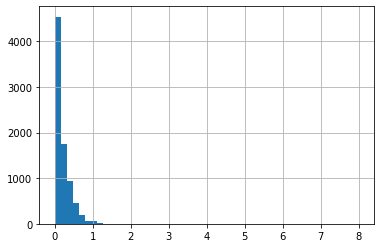

In [ ]:
df_preds['wer'].hist(bins=50)

Lets check WIL

In [ ]:
df_preds['wil'].describe()

count    8007.000000
mean     0.268178   
std      0.266527   
min      0.000000   
25%      0.000000   
50%      0.209877   
75%      0.437500   
max      1.000000   
Name: wil, dtype: float64

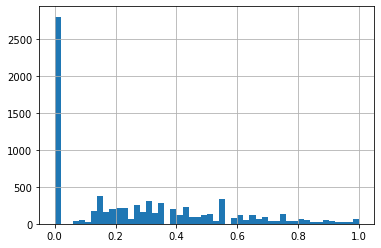

In [ ]:
df_preds['wil'].hist(bins=50)

fuzzywuzzy Levenshtein

In [ ]:
df_preds['fuz_levenshtein'].describe()

count    8007.000000
mean     96.739103  
std      5.010655   
min      32.000000  
25%      96.000000  
50%      98.000000  
75%      100.000000 
max      100.000000 
Name: fuz_levenshtein, dtype: float64

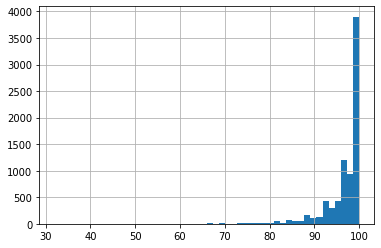

In [ ]:
df_preds['fuz_levenshtein'].hist(bins=50)

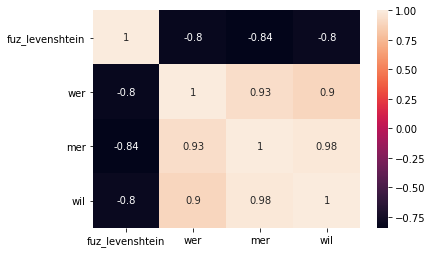

In [ ]:
sn.heatmap(df_preds.corr(), annot=True)
plt.show()

Check our predictions with wer > 1.0

In [ ]:
df_preds[df_preds.wer > 1.0][['preds', 'targets']]

preds                                                                                  targets
31    герац отвудо фвои кодв стало клобалмым ямплением                                            миграция трудовых кадров стала глобальным явлением                                     
40    ебоать еще здеону шестьям строй стан пылутели неду                                          шесть                                                                                  
44    е все страны иа регион на жизнь стремиется способствать это                                 все страны региона должны стремиться способствовать этому                              
115   вни мает машенница                                                                          внимает мошенница                                                                      
127   украйно знакома со меро строитехь с томне по наслышке                                       украина знакома с миростроительством не понаслышке                                     
138   неболея серьез на й оброзлй является вероятна ядерной терроризма                            наиболее серьезной угрозой является вероятно ядерный терроризм                         
381   вам воду сосред ут очиться                                                                  вам надо сосредоточиться                                                               
601   о не розвол                                                                                 полный развал                                                                          
877   прогола жай тлеть не нависть                                                                продолжает тлеть ненависть                                                             
1237  к васут задыку в шининс выкушите з болило                                                   квасу целый кувшинец выкушать изволил                                                  
1732  мыче к мы ведем дедь народам                                                                нашей команде везде дорога                                                             
1733  вапер стеяди значано что бы проведемли и везумевныи что ене вреена цолобча было возобчечны  в этой связи важно чтобы поведение развернутых в стране военнослужащих было безупречным
1806  чего рога фист флерогоофирвал флера графистку                                               флюорографист флюорографировал флюорографистку                                         
1851  велько свески шкоды                                                                         великосветский шкода                                                                   
2205  шо я ыченьные штоны с за клатках                                                            широченные штаны в заплатках                                                           
3763  я вам хороо луши                                                                            я хороший                                                                              
3768  скве арна                                                                                   скверно                                                                                
3816  в том с к ничета онску                                                                      томск не чета омску                                                                    
3921  бсед начеть стощюка у сими деща                                                             тщетно тщится щука ущемить леща                                                        
3922  мы не толимк инсат структуры и устранению инцидентость интеграции системы                   мониторинг инфраструктуры и устранение инцидентов интеграция систем                    
3926  из под приверка из под пыпод вы пртоза йти к спередпо вбертом перевод пыт брдлянулся        из под пригорка из под подвыподверта зайчик с приподвыподвертом переподвыподвернулся   

In [ ]:
import IPython

In [ ]:
cv_test[cv_test.index == 3922][['path','sentence']]

path                                                              sentence
3922  common_voice_ru_23955536.mp3  Мониторинг инфраструктуры и устранение инцидентов, интеграция систем

In [ ]:
df_preds[df_preds.index == 3922]['preds']

3922    мы не толимк инсат структуры и устранению инцидентость интеграции системы
Name: preds, dtype: object

In [ ]:
speech_array, sampling_rate = torchaudio.load(clips_path + cv_test[cv_test.index == 3922]['path'].values[0])

In [ ]:
IPython.display.Audio(data=speech_array, rate=sampling_rate)

In [ ]:
cv_test[cv_test.index == 1733][['path','sentence']]

path                                                                                   sentence
1733  common_voice_ru_18940123.mp3  В этой связи важно, чтобы поведение развернутых в стране военнослужащих было безупречным.

In [ ]:
df_preds[df_preds.index == 1733]['preds']

1733    вапер стеяди значано что бы проведемли и везумевныи что ене вреена цолобча было возобчечны
Name: preds, dtype: object

In [ ]:
speech_array, sampling_rate = torchaudio.load(clips_path + cv_test[cv_test.index == 1733]['path'].values[0])

In [ ]:
IPython.display.Audio(data=speech_array, rate=sampling_rate)

### NeMo ASR 

In [ ]:
!pip install --upgrade omegaconf --pre

     |████████████████████████████████| 81kB 5.5MB/s 
ERROR: nemo-toolkit 1.0.0 has requirement omegaconf<2.1.0,>=2.0.5, but you'll have omegaconf 2.1.0 which is incompatible.
  Found existing installation: omegaconf 2.0.6
    Uninstalling omegaconf-2.0.6:
      Successfully uninstalled omegaconf-2.0.6


In [ ]:
BRANCH = 'v1.0.0'
try:
    import nemo.collections.asr as nemo_asr
except ModuleNotFoundError:
    !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

try:
    from plotly import graph_objects as go
except ModuleNotFoundError:
    !pip install plotly
    from plotly import graph_objects as go

try:
    import ipywidgets
except ModuleNotFoundError:
    !pip install ipywidgets

try:
    import ctc_decoders
except ModuleNotFoundError:
    !apt-get install -y swig
    !git clone https://github.com/NVIDIA/NeMo -b "$BRANCH"
    !cd NeMo && bash scripts/asr_language_modeling/ngram_lm/install_beamsearch_decoders.sh
    print('Restarting Colab runtime to successfully import built module.')
    print('Please re-run the notebook.')
    import os
    os.kill(os.getpid(), 9)

[NeMo W 2021-06-30 03:46:54 optimizers:46] Apex was not found. Using the lamb optimizer will error out.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


[NeMo W 2021-06-30 03:46:58 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text_dali.AudioToCharDALIDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [ ]:
import numpy as np
import librosa
import pandas as pd
import urllib.request
import tarfile
from IPython.display import Audio, display

In [ ]:
nemo_asr.models.EncDecCTCModel.list_available_models()

[PretrainedModelInfo(
 	pretrained_model_name=QuartzNet15x5Base-En,
 	description=QuartzNet15x5 model trained on six datasets: LibriSpeech, Mozilla Common Voice (validated clips from en_1488h_2019-12-10), WSJ, Fisher, Switchboard, and NSC Singapore English. It was trained with Apex/Amp optimization level O1 for 600 epochs. The model achieves a WER of 3.79% on LibriSpeech dev-clean, and a WER of 10.05% on dev-other. Please visit https://ngc.nvidia.com/catalog/models/nvidia:nemospeechmodels for further details.,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo
 ), PretrainedModelInfo(
 	pretrained_model_name=stt_en_quartznet15x5,
 	description=For details about this model, please visit https://ngc.nvidia.com/catalog/models/nvidia:nemo:stt_en_quartznet15x5,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_quartznet15x5/versions/1.0.0rc1/files/stt_en_quartznet15x5.nemo
 ), PretrainedModelInfo(
 	pretr

In [ ]:
asr_model = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name='stt_ru_quartznet15x5', strict=False).cuda()

[NeMo I 2021-06-30 03:47:08 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_ru_quartznet15x5/versions/1.0.0rc1/files/stt_ru_quartznet15x5.nemo to /root/.cache/torch/NeMo/NeMo_1.0.0/stt_ru_quartznet15x5/92506570b7206ea395e295b3fbbf07e3/stt_ru_quartznet15x5.nemo
[NeMo I 2021-06-30 03:47:10 common:675] Instantiating model from pre-trained checkpoint


[NeMo W 2021-06-30 03:47:10 modelPT:138] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /raid/noneval.json
    sample_rate: 16000
    labels:
    - ' '
    - а
    - б
    - в
    - г
    - д
    - е
    - ё
    - ж
    - з
    - и
    - й
    - к
    - л
    - м
    - н
    - о
    - п
    - р
    - с
    - т
    - у
    - ф
    - х
    - ц
    - ч
    - ш
    - щ
    - ъ
    - ы
    - ь
    - э
    - ю
    - я
    batch_size: 16
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    num_workers: 8
    pin_memory: true
    
[NeMo W 2021-06-30 03:47:10 modelPT:145] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation da

[NeMo I 2021-06-30 03:47:10 features:252] PADDING: 16
[NeMo I 2021-06-30 03:47:10 features:269] STFT using torch
[NeMo I 2021-06-30 03:47:18 modelPT:434] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.0.0/stt_ru_quartznet15x5/92506570b7206ea395e295b3fbbf07e3/stt_ru_quartznet15x5.nemo.


In [ ]:
data_url = "https://voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com/cv-corpus-6.1-2020-12-11/ru.tar.gz"
filestream = urllib.request.urlopen(data_url)
data_file = tarfile.open(fileobj=filestream, mode="r|gz")
data_file.extractall()

In [ ]:
cv_test = pd.read_csv("cv-corpus-6.1-2020-12-11/ru/test.tsv", sep='\t')
clips_path = "cv-corpus-6.1-2020-12-11/ru/clips/"

In [ ]:
cv_test.head(3)

client_id  ... segment
0  05743f1d28fcd612b9309ae3d5b93b7f4920a5215c369afeb2893e8f7890e8f7dba333d0c08d50c4272a1202c39a61fa68ac3471a669248c1bb2086d30da5b07  ...  NaN   
1  081340f4cbaab50d8b9606a52488eb0614edd77eb782a4f1b46895bbe07c589d5d8f212673972b3dab6423809baff730eb540165b73d66109ada00230c188275  ...  NaN   
2  14556e94bd8a4402a4f845fcd5154a0fefcda724b436ca0c6aa1629bb1eb5b70697c8fa09df35284573fc1a68b613b37538a1846d1ba0621e17e8c54a09b03f3  ...  NaN   

[3 rows x 10 columns]

In [ ]:
cv_test.shape

(8007, 10)

In [ ]:
paths = list(cv_test.path.values)

In [ ]:
%cd /content/cv-corpus-6.1-2020-12-11/ru/clips/

/content/cv-corpus-6.1-2020-12-11/ru/clips


In [ ]:
%%time
results_sent = []
for path in paths:
    transcript = asr_model.transcribe(paths2audio_files=[path])[0]
    results_sent.append(transcript)

[NeMo W 2021-06-30 03:50:44 patch_utils:50] torch.stft() signature has been updated for PyTorch 1.7+
    Please update PyTorch to remain compatible with later versions of NeMo.
[NeMo W 2021-06-30 03:50:44 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning:
    
    floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
    To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
    
    


In [ ]:
%cd /content/

#### Data preprocessing

In [ ]:
pd_res = pd.read_csv("nemo_results.csv")

In [ ]:
pd_res.columns

Index(['Unnamed: 0', '0'], dtype='object')

In [ ]:
pd_res = pd_res.drop('Unnamed: 0', axis=1)

In [ ]:
pd_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8007 entries, 0 to 8006
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       8006 non-null   object
dtypes: object(1)
memory usage: 62.7+ KB


In [ ]:
pd_res['sentence'] = cv_test['sentence']
pd_res['sentence'] = pd_res['sentence'].apply(clean_sentence)
pd_res['sentence'] = pd_res['sentence'].apply(str)
pd_res['0'] = pd_res['0'].apply(str)

pd_res.columns = ['hypotesis', 'text']
# pd_res = pd_res.reset_index()

In [ ]:
pd_res['hypotesis'].isna().sum()

0

In [ ]:
pd_res.head(3)

hypotesis                                                                                                     text
0  он работать а ее не удержать никак бегается клёшемь каждого убульпарника                                  он работать а ее не удержать никак бегает за клешем каждого бульварника                                
1  если не буди возражений я буду считать что ассамблея согласна с этим предложением                         если не будет возражений я буду считать что ассамблея согласна с этим предложением                     
2  палестинцам необходимо сначала установить сни мер фиврелем а затен думеваций признания государственности  палестинцам необходимо сначала установить мир с израилем а затем добиваться признания государственности

In [ ]:
wer, mer, wil, fuz = [], [], [], []
for line in tqdm(pd_res.values):
    text = line[1]
    hypothesis = line[0]

    fuz.append(fuzz.WRatio(text, hypothesis))


    measures = jiwer.compute_measures(text, hypothesis)
    wer.append(measures['wer'])
    mer.append(measures['mer'])
    wil.append(measures['wil'])

In [ ]:
pd_res['fuz_levenshtein'] = pd.DataFrame(fuz)
pd_res['wer'] = pd.DataFrame(wer)
pd_res['mer'] = pd.DataFrame(mer)
pd_res['wil'] = pd.DataFrame(wil)

count    8007.000000
mean     0.205885   
std      0.242779   
min      0.000000   
25%      0.000000   
50%      0.125000   
75%      0.333333   
max      2.000000   
Name: wer, dtype: float64


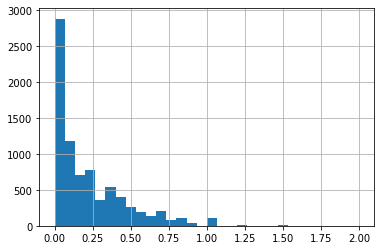

In [ ]:
print(pd_res['wer'].describe())
pd_res['wer'].hist(bins=30)

count    8007.000000
mean     0.294584   
std      0.299867   
min      0.000000   
25%      0.000000   
50%      0.224359   
75%      0.515152   
max      1.000000   
Name: wil, dtype: float64


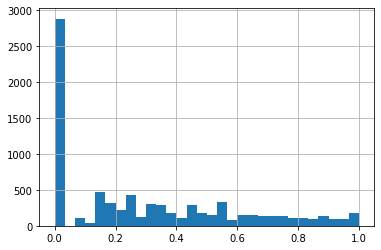

In [ ]:
print(pd_res['wil'].describe())
pd_res['wil'].hist(bins=30)

count    8007.000000
mean     95.796178  
std      6.748445   
min      0.000000   
25%      95.000000  
50%      98.000000  
75%      100.000000 
max      100.000000 
Name: fuz_levenshtein, dtype: float64


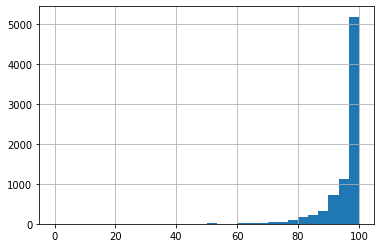

In [ ]:
print(pd_res['fuz_levenshtein'].describe())
pd_res['fuz_levenshtein'].hist(bins=30)

## Arabic

In [ ]:
!pip install lang_trans

  Created wheel for lang-trans: filename=lang_trans-0.6.0-cp37-none-any.whl size=6347 sha256=421266c8523f762960f1e8ce545ab4e9fe90ad22aa4543b2eec76f8f47a1ffb4
  Stored in directory: /root/.cache/pip/wheels/f2/b9/9a/0990a0b22fd12190658d7539bbfec841de1324b9fb247f1c1b
Successfully built lang-trans


In [ ]:
import jiwer
import torch
import torchaudio
import numpy as np
import IPython
from datasets import load_dataset
from lang_trans.arabic import buckwalter
from transformers import set_seed, Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2CTCTokenizer

set_seed(42)

In [ ]:
dataset.keys()

dict_keys(['train', 'test', 'validation', 'other', 'invalidated'])

In [ ]:
dataset = load_dataset("common_voice", "ar", split='other')
resamplers = {
    48000: torchaudio.transforms.Resample(48000, 16000),
    44100: torchaudio.transforms.Resample(44100, 16000),
    32000: torchaudio.transforms.Resample(32000, 16000),
}

Dataset common_voice downloaded and prepared to /root/.cache/huggingface/datasets/common_voice/ar/6.1.0/078d412587e9efeb0ae2e574da99c31e18844c496008d53dc5c60f4159ed639b. Subsequent calls will reuse this data.


In [ ]:
dataset.to_pandas().shape

(18283, 10)

In [ ]:
def prepare_example(example):
    speech, sampling_rate = torchaudio.load(example["path"])
    if sampling_rate in resamplers:
        example["speech"] = resamplers[sampling_rate](speech).squeeze().numpy()
    else:
        example["speech"] = resamplers[4800](speech).squeeze().numpy()
    return example

In [ ]:
dataset = dataset.map(prepare_example)

## Audio files analysis

In [ ]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras


In [ ]:
processor = Wav2Vec2Processor.from_pretrained("bakrianoo/sinai-voice-ar-stt")
# tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("bakrianoo/sinai-voice-ar-stt")
model = Wav2Vec2ForCTC.from_pretrained("bakrianoo/sinai-voice-ar-stt").to('cuda').eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# processor.tokenizer.get_vocab()

In [ ]:
def predict(batch):
    inputs = processor(batch["speech"], sampling_rate=16000, return_tensors="pt", padding=True)
    with torch.no_grad():
        predicted = torch.argmax(model(inputs.input_values.to("cuda")).logits, dim=-1)
    
    predicted[predicted == -100] = processor.tokenizer.pad_token_id  # see fine-tuning script
    # here we can try to use LANGUAGE MODEL
    batch["predicted"] = processor.tokenizer.batch_decode(predicted)
    return batch

In [ ]:
dataset = dataset.map(predict, batched=True, batch_size=16, remove_columns=["speech"])

#### Buckwalter transliteration https://en.wikipedia.org/wiki/Buckwalter_transliteration

In [ ]:
truth_buckwalter=[buckwalter.trans(s) for s in dataset["sentence"]]
predicted_buckwalter=[buckwalter.trans(s) for s in dataset["predicted"]]

In [ ]:
trans_df = pd.DataFrame()
trans_df['truth'] = truth_buckwalter
trans_df['predicted'] = predicted_buckwalter
trans_df['truth'] = trans_df['truth'].apply(str)
trans_df['predicted'] = trans_df['predicted'].apply(str)

In [ ]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18283 entries, 0 to 18282
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   truth      18283 non-null  object
 1   predicted  18283 non-null  object
dtypes: object(2)
memory usage: 285.8+ KB


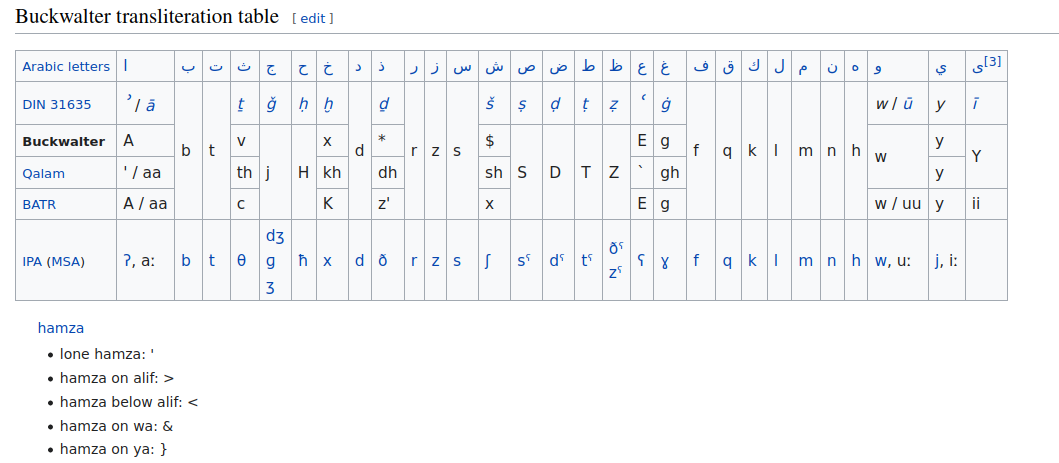

In [ ]:
trans_df.head(10)

truth                                                    predicted
0  tt>lf h*h AlnZryp mn vlAvp >jzA'.                               tt>lf HAzh AlnzAryp mn slAsp EzA'                          
1  EndmA kAnt Tflp Sgyrp ، kAnt qAdrp ElY AlgnA' HtY qbl >n ttHdv  EndmA kAnt Tflp Sgyr kAnt qAdrp ElY AlgnA' HtY qbl >n ttHdv
2  AlklmAt lA ysEhA AltEbyr En HznhA AlEmyq.                       AlklmAt lA ysEhA AltAbyr En AHjhA AlEmyb                   
3  >$trythA Alywm >m AlbArHp ؟                                     >$trythA Alywm Em AlbArHp                                  
4  lA lltTrf >yAF kAn.                                             nAlt tTrw fy EyA kAn                                       
5  <nk tEy$ mrp wAHdp lA gyr.                                      <nk tEy$ mrp wAHdp lA gyr                                  
6  mn Al>fDl lk >n t*hb Al|n.                                      mn Al>fDl lk >n t*hb Al|n                                  
7  wSlnA <lY Almktb fy Alwqt AlmTlwb.                              wSlnA <lY Almktb fy Alwqt Almtrwb                          
8  >klt AlSbr w*qt Almr flm >rY $y}A >mr mn Alfqr.                 >klt AlSbr w*qt Almrp flm >r $y}A >mr mn Alfqr             
9  TAlEhA fy qAmwsk.                                               TAlEhA fy qAmwsk

In [ ]:
speech_array, sampling_rate = torchaudio.load(dataset.to_pandas().path[9])
IPython.display.Audio(data=speech_array, rate=sampling_rate)

In [ ]:
for reference, predicted in zip(dataset["sentence"][:20], dataset["predicted"][:20]):
      print("reference:", reference)
      print("predicted:", predicted)
      print("--")

reference: تتألف هذه النظرية من ثلاثة أجزاء.
predicted: تتألف حازه النزارية من سلاسة عزاء
--
reference: عندما كانت طفلة صغيرة ، كانت قادرة على الغناء حتى قبل أن تتحدث
predicted: عندما كانت طفلة صغير كانت قادرة على الغناء حتى قبل أن تتحدث
--
reference: الكلمات لا يسعها التعبير عن حزنها العميق.
predicted: الكلمات لا يسعها التابير عن احجها العميب
--
reference: أشتريتها اليوم أم البارحة ؟
predicted: أشتريتها اليوم عم البارحة
--
reference: لا للتطرف أياً كان.
predicted: نالت تطرو في عيا كان
--
reference: إنك تعيش مرة واحدة لا غير.
predicted: إنك تعيش مرة واحدة لا غير
--
reference: من الأفضل لك أن تذهب الآن.
predicted: من الأفضل لك أن تذهب الآن
--
reference: وصلنا إلى المكتب في الوقت المطلوب.
predicted: وصلنا إلى المكتب في الوقت المتروب
--
reference: أكلت الصبر وذقت المر فلم أرى شيئا أمر من الفقر.
predicted: أكلت الصبر وذقت المرة فلم أر شيئا أمر من الفقر
--
reference: طالعها في قاموسك.
predicted: طالعها في قاموسك
--
reference: تجري الرياح بما لا تشتهي السفن
predicted: تجري الرياح بما لا تشته

In [ ]:
df = dataset.to_pandas()

In [ ]:
df.head(3)

accent  ... up_votes
0         ...  0      
1         ...  1      
2         ...  1      

[3 rows x 11 columns]

#### klaam

In [ ]:
!git clone https://github.com/ARBML/klaam
%cd klaam

Cloning into 'klaam'...
remote: Enumerating objects: 519, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 519 (delta 41), reused 48 (delta 21), pack-reused 447
Receiving objects: 100% (519/519), 134.53 MiB | 36.75 MiB/s, done.
Resolving deltas: 100% (231/231), done.
/content/klaam


In [ ]:
%%capture
!pip install -r requirements.txt

In [ ]:
%%capture
classes = []
for path in df['path'].values:
      res = model.classify(path)
      classes.append(res)
      

In [ ]:
import tqdm

In [ ]:
transformation = jiwer.Compose([
    # normalize some diacritics, remove punctuation, and replace Persian letters with Arabic ones
    jiwer.SubstituteRegexes({
        r'[auiFNKo\~_،؟»\?;:\-,\.؛«!"]': "", "\u06D6": "",
        r"[\|\{]": "A", "p": "h", "ک": "k", "ی": "y"}),
    # default transformation below
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.SentencesToListOfWords(),
    jiwer.RemoveEmptyStrings(),
])

In [ ]:
eval_df = pd.DataFrame([], columns=["actual_text", "predicted_text", 
                                    "fuzzy_levenshtein", "wer"])

for sentence, predicted in tqdm.tqdm_notebook(zip(trans_df['truth'].values, 
                                                  trans_df['predicted'].values)):   
        
        # wav_name = os.path.basename(wav_path)
        levenshtein = fuzz.WRatio(sentence, predicted)
        wer = jiwer.wer(sentence, predicted, truth_transform=transformation,
                        hypothesis_transform=transformation)
        

        eval_df = eval_df.append({"actual_text": sentence,"predicted_text": predicted,
                                  "fuzzy_levenshtein": levenshtein, "wer": wer}, ignore_index=True)
        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
# #example how transformer works 

# jiwer.Compose([
#     # normalize some diacritics, remove punctuation, and replace Persian letters with Arabic ones
#     jiwer.SubstituteRegexes({
#         r'[auiFNKo\~_،؟»\?;:\-,\.؛«!"]': "", "\u06D6": "",
#         r"[\|\{]": "A", "p": "h", "ک": "k", "ی": "y"}),
#     # default transformation below
#     jiwer.RemoveMultipleSpaces(),
#     jiwer.Strip(),
#     jiwer.SentencesToListOfWords(),
#     jiwer.RemoveEmptyStrings(),
# ])([trans_df['truth'][0], trans_df['predicted'][0]])

['>ldyk', 'qlm', '>ldyk', 'qlm']

In [ ]:
eval_df

actual_text  ...       wer
0      tt>lf h*h AlnZryp mn vlAvp >jzA'.                                                                             ...  0.666667
1      EndmA kAnt Tflp Sgyrp ، kAnt qAdrp ElY AlgnA' HtY qbl >n ttHdv                                                ...  0.083333
2      AlklmAt lA ysEhA AltEbyr En HznhA AlEmyq.                                                                     ...  0.428571
3      >$trythA Alywm >m AlbArHp ؟                                                                                   ...  0.250000
4      lA lltTrf >yAF kAn.                                                                                           ...  1.000000
...                    ...                                                                                           ...       ...
18278  lqd xasira twm.                                                                                               ...  0.000000
18279  wllmTlqAt mtAE bAlmErwf HqA ElY Almtqyn                                                                       ...  0.166667
18280  >nA jAdN~ yA mAry.                                                                                            ...  0.250000
18281  faqado ka*~abuwA biAloHaq~i lam~aA jaA'ahumo fasawofa ya>otiyhimo >anobaA'u maA kaAnuwA bihi yasotahozi}uwna  ...  0.083333
18282  lqd Akmlt twA qrA'p h*A AlktAb.                                                                               ...  0.166667

[18283 rows x 4 columns]

In [ ]:
eval_df = eval_df[eval_df.wer < 1.0]

In [ ]:
eval_df['fuzzy_levenshtein'].isna().sum()

0

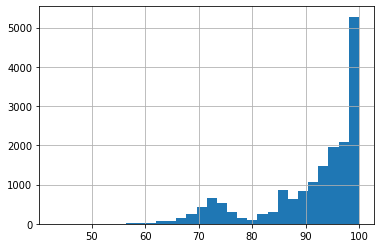

In [ ]:
eval_df['fuzzy_levenshtein'].hist(bins=30)

In [ ]:
eval_df['wer'].describe()

count    17448.000000
mean     0.221615    
std      0.235475    
min      0.000000    
25%      0.000000    
50%      0.181818    
75%      0.375000    
max      0.928571    
Name: wer, dtype: float64

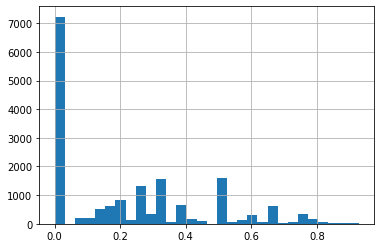

In [ ]:
eval_df['wer'].hist(bins=30)

In [ ]:
transformation = jiwer.Compose([
    # normalize some diacritics, remove punctuation, and replace Persian letters with Arabic ones
    jiwer.SubstituteRegexes({
        r'[auiFNKo\~_،؟»\?;:\-,\.؛«!"]': "", "\u06D6": "",
        r"[\|\{]": "A", "p": "h", "ک": "k", "ی": "y"}),
    # default transformation below
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.SentencesToListOfWords(),
    jiwer.RemoveEmptyStrings(),
])

In [ ]:
metrics = jiwer.compute_measures(
    truth=[buckwalter.trans(s) for s in dataset["sentence"]],  # Buckwalter transliteration
    hypothesis=[buckwalter.trans(s) for s in dataset["predicted"]],
    truth_transform=transformation,
    hypothesis_transform=transformation,
)

In [ ]:
print(f"WER: {metrics['wer']:.2%}")
print(f"MER: {metrics['mer']:.2%}")
print(f"WIL: {metrics['wil']:.2%}")
print(f"WIP: {metrics['wip']:.2%}")

WER: 39.25%
MER: 38.24%
WIL: 58.79%
WIP: 41.21%


In [ ]:
dataframe = dataset.to_pandas()[['sentence', 'predicted']]

In [ ]:
dataframe.head()

sentence                                      predicted
0  ألديك قلم ؟                                     ألديك قلم                                    
1  ليست هناك مسافة على هذه الأرض أبعد من يوم أمس.  ليست نارك مسافة على هذه الأرض أبعد من يوم أمس
2  إنك تكبر المشكلة.                               إنك تكبر المشكلة                             
3  يرغب أن يلتقي بك.                               يرغب أن يلتقي بك                             
4  إنهم لا يعرفون لماذا حتى.                       إنهم لا يعرفون لماذا حتى

In [ ]:
wer, mer, wil, fuz = [], [], [], []
for hypothesis, text in zip(dataframe.values[:,1], dataframe.values[:,0]):
    fuz.append(fuzz.WRatio(text, hypothesis))


    measures = jiwer.compute_measures(text, hypothesis)
    wer.append(measures['wer'])
    mer.append(measures['mer'])
    wil.append(measures['wil'])

In [ ]:
df_preds = pd.DataFrame()
df_preds['fuz_levenshtein'] = fuz
df_preds['wer'] = wer
df_preds['mer'] = mer
df_preds['wil'] = wil

In [ ]:
df_preds.fuz_levenshtein.describe()

count    7622.000000
mean     90.565206  
std      10.569067  
min      0.000000   
25%      86.000000  
50%      94.000000  
75%      100.000000 
max      100.000000 
Name: fuz_levenshtein, dtype: float64

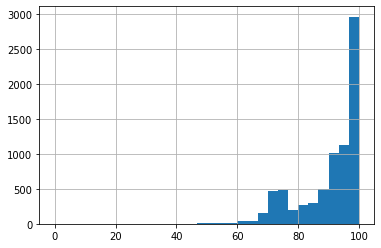

In [ ]:
df_preds.fuz_levenshtein.hist(bins=30)

In [ ]:
# levenshtein between 5 and 50 percentiles
mountain = df_preds[(df_preds.fuz_levenshtein > 65) & 
                    (df_preds.fuz_levenshtein < 90)]['fuz_levenshtein']
mount_indexes = mountain.index
mountain.shape

(2393,)

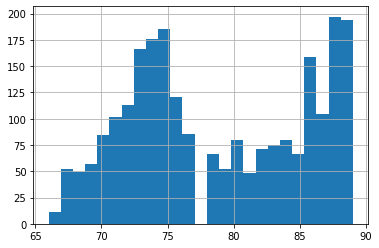

In [ ]:
mountain.hist(bins=25)

In [ ]:
sub_mountain = df_preds[(df_preds.fuz_levenshtein > 70) & 
                    (df_preds.fuz_levenshtein < 80)]

In [ ]:
sub_mountain.index

Int64Index([   9,   23,   34,   51,   76,   89,   95,  106,  108,  123,
            ...
            7495, 7503, 7504, 7545, 7551, 7558, 7560, 7561, 7582, 7592],
           dtype='int64', length=1066)

In [ ]:
sub_m_indexes = sub_mountain.index

In [ ]:
# dialects hypothesys
# paths_sub = []
# for index in sub_m_indexes:
#     paths_sub.append(df.loc[index,:]['path'])
paths_sub = [df.loc[index,:]['path'] for index in sub_m_indexes]

In [ ]:
sent_sub = [dataframe.loc[index,:]['sentence'] for index in sub_m_indexes]
pred_sub = [dataframe.loc[index,:]['predicted'] for index in sub_m_indexes]


In [ ]:
sent_pred = pd.DataFrame([], columns=['sentence', 'predicted'])

In [ ]:
sent_pred['sentence'] = sent_sub
sent_pred['predicted'] = pred_sub

In [ ]:
sent_pred.to_csv('sent_pred.csv')

In [ ]:
len(paths_sub)

1066

In [ ]:
from klaam import SpeechClassification
model = SpeechClassification()

In [ ]:
import tqdm

In [ ]:
classes = []
for path in tqdm.tqdm_notebook(paths_sub):
      res = model.classify(path)
      classes.append(res)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

In [ ]:
dialects_bd_sub = pd.DataFrame(classes, columns=['ind'])
dialects_bd_sub.value_counts()

ind
MSA    887
NOR    69 
GLF    50 
LAV    41 
EGY    19 
dtype: int64

In [ ]:
dialects_bd_sub.value_counts().sum()

1066

<BarContainer object of 5 artists>

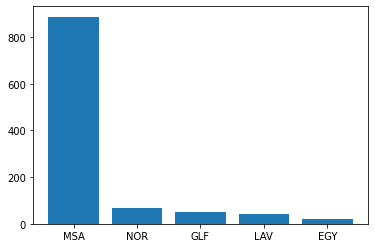

In [ ]:
plt.bar(dialects_bd_sub['ind'].value_counts().index ,dialects_bd_sub.value_counts())

In [ ]:
dialects_bd_sub.to_csv('dialects_sub.csv')

In [ ]:
# more than 90
sub_mountain_9_idx = df_preds[df_preds.fuz_levenshtein > 98].index

In [ ]:
len(sub_mountain_9_idx)

2165

In [ ]:
paths_sub = [df.loc[index,:]['path'] for index in sub_mountain_9_idx]
assert len(paths_sub) == len(sub_mountain_9_idx)

In [ ]:
new_classes = []
for path in tqdm.tqdm_notebook(paths_sub):
      res = model.classify(path)
      new_classes.append(res)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

In [ ]:
dialects_bd_sub_9 = pd.DataFrame(new_classes, columns=['ind'])


In [ ]:
dialects_bd_sub_9['ind'].value_counts()

MSA    1824
NOR    159 
GLF    77  
LAV    70  
EGY    35  
Name: ind, dtype: int64

<BarContainer object of 5 artists>

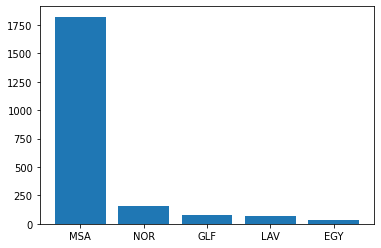

In [ ]:
plt.bar(dialects_bd_sub_9['ind'].value_counts().index ,dialects_bd_sub_9.value_counts())

In [ ]:
dialects_bd_sub_9.to_csv('dialects_sub_9.csv')

In [ ]:
dataframe.to_csv('sent_pred.csv')

# multilingual asr on 56 languages

In [ ]:
%%capture
!pip install torchaudio
!pip install datasets transformers
!pip install asrp
!wget -O lang_ids.pk https://huggingface.co/voidful/wav2vec2-xlsr-multilingual-56/raw/main/lang_ids.pk

In [ ]:
import torchaudio
from datasets import load_dataset, load_metric
from transformers import (
    Wav2Vec2ForCTC,
    Wav2Vec2Processor,
    AutoTokenizer, 
    AutoModelWithLMHead 
)
import torch
import re
import sys
import soundfile as sf
model_name = "voidful/wav2vec2-xlsr-multilingual-56"
device = "cuda"
processor_name = "voidful/wav2vec2-xlsr-multilingual-56"

In [ ]:
import pickle
with open("lang_ids.pk", 'rb') as output:
    lang_ids = pickle.load(output)

In [ ]:
model = Wav2Vec2ForCTC.from_pretrained(model_name).to(device)
processor = Wav2Vec2Processor.from_pretrained(processor_name)

model.eval()

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureExtractor(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (1): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (2): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (3): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (4): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,)

In [ ]:
def load_file_to_data(file, sampling_rate=16_000):
    batch = {}
    speech, _ = torchaudio.load(file)
    if sampling_rate != '16_000' or sampling_rate != '16000':
        resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16_000)
        batch["speech"] = resampler.forward(speech.squeeze(0)).numpy()
        batch["sampling_rate"] = resampler.new_freq
    else:
        batch["speech"] = speech.squeeze(0).numpy()
        batch["sampling_rate"] = '16000'
    return batch


In [ ]:
audio, rate = librosa.load("untitled.wav", sr = 16000)

model_name = "facebook/wav2vec2-large-xlsr-53-dutch"
device = "cpu"
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'  # noqa: W605

processor = Wav2Vec2Processor.from_pretrained(model_name)
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name).to(device)

input_values = processor(audio, sampling_rate = rate, return_tensors = 'pt').input_values
logits = model(input_values).logits

predicted_ids = torch.argmax(logits, dim =-1)

#decode the audio to generate text (CAN I USE ROBERTA HERE?)
transcriptions = tokenizer.decode(predicted_ids[0])

#print result
print(transcriptions)

In [ ]:
def predict(data):
    features = processor(data["speech"], sampling_rate=data["sampling_rate"], padding=True, return_tensors="pt")
    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)
    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits
        decoded_results = []
        for logit in logits:
            pred_ids = torch.argmax(logit, dim=-1)
            mask = pred_ids.ge(1).unsqueeze(-1).expand(logit.size())
            vocab_size = logit.size()[-1]
            voice_prob = torch.nn.functional.softmax((torch.masked_select(logit, mask).view(-1,vocab_size)),dim=-1)
            comb_pred_ids = torch.argmax(voice_prob, dim=-1)
            decoded_results.append(processor.decode(comb_pred_ids))
    return decoded_results

In [ ]:
def predict_lang_specific(data, lang_code):
    features = processor(data["speech"], sampling_rate=data["sampling_rate"], padding=True, return_tensors="pt")
    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)
    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits
        decoded_results = []
        for logit in logits:
            pred_ids = torch.argmax(logit, dim=-1)
            mask = ~pred_ids.eq(processor.tokenizer.pad_token_id).unsqueeze(-1).expand(logit.size())
            vocab_size = logit.size()[-1]
            voice_prob = torch.nn.functional.softmax((torch.masked_select(logit, mask).view(-1,vocab_size)),dim=-1)
            filtered_input = pred_ids[pred_ids!=processor.tokenizer.pad_token_id].view(1,-1).to(device)
            if len(filtered_input[0]) == 0:
                decoded_results.append("")
            else:
                lang_mask = torch.empty(voice_prob.shape[-1]).fill_(0)
                lang_index = torch.tensor(sorted(lang_ids[lang_code]))
                lang_mask.index_fill_(0, lang_index, 1)
                lang_mask = lang_mask.to(device)
                comb_pred_ids = torch.argmax(lang_mask*voice_prob, dim=-1)
                decoded_results.append(processor.decode(comb_pred_ids))

    return decoded_results

In [ ]:
df.loc[0]

accent                                                                                                                                                                                             
age           thirties                                                                                                                                                                             
client_id     6fd885b5ae246c0f125138cdd66534a8d6670745bcf2690c8bdd9e4af4a5ee370d325f7725b74bed2670d22b1774bbbee7bef6172d33b7cb431b2b1e13eaca3d                                                     
down_votes    2                                                                                                                                                                                    
gender        female                                                                                                                                                                               
locale        ar    

'/root/.cache/huggingface/datasets/downloads/extracted/d683d02b419074b255de0b64800dd56845f714dbe57db09390b0ee84f10622e7/cv-corpus-6.1-2020-12-11/ar/clips/common_voice_ar_19058370.mp3'

In [ ]:
# predict(load_file_to_data(df.loc[0]['path'],sampling_rate=16_000)) # beware of the audio file sampling rate

predict_lang_specific(load_file_to_data(df.loc[0]['path'],sampling_rate=16_000),'ar') # beware of the audio file sampling rate


['ا هیکا رهر امه نراختی']

In [ ]:
#ASR RECOGNITION library
!pip install asrecognition

In [ ]:
from asrecognition import ASREngine

In [ ]:
# 1 - Load the ASR engine for a given language (on the first run it may take a while)
asr = ASREngine("ar")

Downloading:   0%|          | 0.00/158 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

In [ ]:
asr.transcribe(['example.wav'])

[{'path': 'example.wav', 'transcription': 'يرغب أن يلتقي بك'}]